## Multi-task recommenders

In [1]:
import os
import pprint
import tempfile

from typing import Dict, Text

import numpy as np
import tensorflow as tf
import tensorflow_recommenders as tfrs
import pandas as pd
from firebase import firebase
import matplotlib.pyplot as plt

### Preparing the dataset

In [2]:
firebase = firebase.FirebaseApplication('firebase-code', None)
firebase_ratings = firebase.get('/User_Book', None)
firebase_books = firebase.get('/Books', None)

In [3]:
ratings_df = pd.DataFrame.from_dict(firebase_ratings, orient='index')
books_df = pd.DataFrame.from_dict(firebase_books, orient='index')

In [4]:
ratings_df.head()

,bookId,isbn,myRate,userId
-NWcEFgMwmdaYc-4ndml,-NWcEFeoVaEgjMwiboCA,09781565841000,5.0,3avc3TUJioP8XGD0bLK9xtV7uIG3
-NWcEGniRUJ0hRQmvclo,-NWcEGmQeH3eiHRZ0w7G,09781929610259,4.5,3avc3TUJioP8XGD0bLK9xtV7uIG3
-NWcEHtzsgGbN7rpUZ6V,-NWcEHsFfJ3yqXud1NGo,09780814326114,4.0,3avc3TUJioP8XGD0bLK9xtV7uIG3
-NWcEJunG4PfX-aAVxiF,-NWcEJqjxIyMQv5izHrS,09780312010447,4.5,3avc3TUJioP8XGD0bLK9xtV7uIG3
-NWcELFol68JZpsfvkyF,-NWcELEEV0QR6EHobxIe,09780143036357,3.5,3avc3TUJioP8XGD0bLK9xtV7uIG3


In [5]:
len(set(books_df["isbn"]))

704

In [6]:
len(books_df)

1011

In [7]:
books_df = pd.DataFrame(set(books_df["isbn"]),columns=["isbn"])

In [8]:
len(books_df)

704

In [9]:
ratings_dataset = tf.data.Dataset.from_tensor_slices(dict(ratings_df))
books_dataset = tf.data.Dataset.from_tensor_slices(dict(books_df))

In [10]:
ratings = ratings_dataset.map(lambda x: {
    "book_isbn": x["isbn"],
    "user_id": x["userId"],
    "user_rating": x["myRate"],
})
books = books_dataset.map(lambda x: x["isbn"])

In [11]:
len(books)

704

In [12]:
len(ratings)

1011

In [13]:
# Randomly shuffle data and split between train and test.
tf.random.set_seed(42)
shuffled = ratings.shuffle(len(ratings_df), seed=42, reshuffle_each_iteration=False)

train = shuffled.take(800)
test = shuffled.skip(800).take(210)

book_isbns = books.batch(25) #100 50
user_ids = ratings.batch(10_000).map(lambda x: x["user_id"])

unique_book_isbns = np.unique(np.concatenate(list(book_isbns)))
unique_user_ids = np.unique(np.concatenate(list(user_ids)))

## A multi-task model

In [14]:
class BookModel(tfrs.models.Model):

    def __init__(self, rating_weight: float, retrieval_weight: float) -> None:
        # We take the loss weights in the constructor: this allows us to instantiate
        # several model objects with different loss weights.

        super().__init__()

        embedding_dimension = 64 #32

        # User and book models.
        self.book_model: tf.keras.layers.Layer = tf.keras.Sequential([
          tf.keras.layers.StringLookup(
            vocabulary=unique_book_isbns, mask_token=None),
          tf.keras.layers.Embedding(len(unique_book_isbns) + 1, embedding_dimension)
        ])
        self.user_model: tf.keras.layers.Layer = tf.keras.Sequential([
          tf.keras.layers.StringLookup(
            vocabulary=unique_user_ids, mask_token=None),
          tf.keras.layers.Embedding(len(unique_user_ids) + 1, embedding_dimension)
        ])

        # A small model to take in user and book embeddings and predict ratings.
        # We can make this as complicated as we want as long as we output a scalar
        # as our prediction.
        self.rating_model = tf.keras.Sequential([
            tf.keras.layers.Dense(512, activation="relu"),
            tf.keras.layers.Dropout(0.3),
            tf.keras.layers.Dense(256, activation="relu"),
            tf.keras.layers.Dropout(0.2),
            tf.keras.layers.Dense(128, activation="relu"),
            tf.keras.layers.Dropout(0.2),
            tf.keras.layers.Dense(32, activation="relu"),
            tf.keras.layers.Dense(1),
        ])

        # The tasks.
        self.rating_task: tf.keras.layers.Layer = tfrs.tasks.Ranking(
            loss=tf.keras.losses.MeanSquaredError(),
            metrics=[tf.keras.metrics.RootMeanSquaredError()],
        )
        self.retrieval_task: tf.keras.layers.Layer = tfrs.tasks.Retrieval(
            metrics=tfrs.metrics.FactorizedTopK(
                candidates=books.batch(16).map(self.book_model) #128 32
            )
        )

        # The loss weights.
        self.rating_weight = rating_weight
        self.retrieval_weight = retrieval_weight

    def call(self, features: Dict[Text, tf.Tensor]) -> tf.Tensor:
        # We pick out the user features and pass them into the user model.
        user_embeddings = self.user_model(features["user_id"])
        # And pick out the book features and pass them into the book model.
        book_embeddings = self.book_model(features["book_isbn"])

        return (
            user_embeddings,
            book_embeddings,
            # We apply the multi-layered rating model to a concatentation of
            # user and book embeddings.
            self.rating_model(
                tf.concat([user_embeddings, book_embeddings], axis=1)
            ),
        )

    def compute_loss(self, features: Dict[Text, tf.Tensor], training=False) -> tf.Tensor:

        ratings = features.pop("user_rating")

        user_embeddings, book_embeddings, rating_predictions = self(features)

        # We compute the loss for each task.
        rating_loss = self.rating_task(
            labels=ratings,
            predictions=rating_predictions,
        )
        retrieval_loss = self.retrieval_task(user_embeddings, book_embeddings)
        # And combine them using the loss weights.
        return (self.rating_weight * rating_loss
                + self.retrieval_weight * retrieval_loss)

## Rating-specialized model

In [15]:
model = BookModel(rating_weight=1.0, retrieval_weight=0.0)
model.compile(optimizer=tf.keras.optimizers.AdamW(0.001))

In [16]:
cached_train = train.shuffle(800).batch(32).cache() #128 64
cached_test = test.batch(16).cache() #64 32

In [17]:
history_rating_model = model.fit(cached_train, epochs= 100)
metrics = model.evaluate(cached_test, return_dict=True)

print(f"Retrieval top-100 accuracy: {metrics['factorized_top_k/top_100_categorical_accuracy']:.3f}.")
print(f"Ranking RMSE: {metrics['root_mean_squared_error']:.3f}.")

Epoch 1/100
25/25 [==============================] - 7s 90ms/step - root_mean_squared_error: 2.4889 - factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_5_categorical_accuracy: 0.0037 - factorized_top_k/top_10_categorical_accuracy: 0.0088 - factorized_top_k/top_50_categorical_accuracy: 0.0650 - factorized_top_k/top_100_categorical_accuracy: 0.1350 - loss: 5.9950 - regularization_loss: 0.0000e+00 - total_loss: 5.9950
Epoch 2/100
25/25 [==============================] - 2s 90ms/step - root_mean_squared_error: 1.1763 - factorized_top_k/top_1_categorical_accuracy: 0.0012 - factorized_top_k/top_5_categorical_accuracy: 0.0063 - factorized_top_k/top_10_categorical_accuracy: 0.0125 - factorized_top_k/top_50_categorical_accuracy: 0.0688 - factorized_top_k/top_100_categorical_accuracy: 0.1350 - loss: 1.3696 - regularization_loss: 0.0000e+00 - total_loss: 1.3696
Epoch 3/100
25/25 [==============================] - 2s 75ms/step - root_mean_squared_error: 0.9824 - factor

25/25 [==============================] - 2s 91ms/step - root_mean_squared_error: 0.2425 - factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_5_categorical_accuracy: 0.0050 - factorized_top_k/top_10_categorical_accuracy: 0.0150 - factorized_top_k/top_50_categorical_accuracy: 0.0825 - factorized_top_k/top_100_categorical_accuracy: 0.1550 - loss: 0.0572 - regularization_loss: 0.0000e+00 - total_loss: 0.0572
Epoch 38/100
25/25 [==============================] - 2s 73ms/step - root_mean_squared_error: 0.2831 - factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_5_categorical_accuracy: 0.0050 - factorized_top_k/top_10_categorical_accuracy: 0.0137 - factorized_top_k/top_50_categorical_accuracy: 0.0838 - factorized_top_k/top_100_categorical_accuracy: 0.1525 - loss: 0.0811 - regularization_loss: 0.0000e+00 - total_loss: 0.0811
Epoch 39/100
25/25 [==============================] - 2s 79ms/step - root_mean_squared_error: 0.2386 - factorized_t

25/25 [==============================] - 2s 67ms/step - root_mean_squared_error: 0.1960 - factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_5_categorical_accuracy: 0.0075 - factorized_top_k/top_10_categorical_accuracy: 0.0175 - factorized_top_k/top_50_categorical_accuracy: 0.0838 - factorized_top_k/top_100_categorical_accuracy: 0.1688 - loss: 0.0378 - regularization_loss: 0.0000e+00 - total_loss: 0.0378
Epoch 74/100
25/25 [==============================] - 2s 66ms/step - root_mean_squared_error: 0.1689 - factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_5_categorical_accuracy: 0.0063 - factorized_top_k/top_10_categorical_accuracy: 0.0175 - factorized_top_k/top_50_categorical_accuracy: 0.0838 - factorized_top_k/top_100_categorical_accuracy: 0.1700 - loss: 0.0291 - regularization_loss: 0.0000e+00 - total_loss: 0.0291
Epoch 75/100
25/25 [==============================] - 2s 71ms/step - root_mean_squared_error: 0.1824 - factorized_t

## Retrieval-specialized model

In [18]:
model = BookModel(rating_weight=0.0, retrieval_weight=1.0)
model.compile(optimizer=tf.keras.optimizers.AdamW(0.001))

In [19]:
history_retrieval_model = model.fit(cached_train, epochs= 100)
metrics = model.evaluate(cached_test, return_dict=True)

print(f"Retrieval top-100 accuracy: {metrics['factorized_top_k/top_100_categorical_accuracy']:.3f}.")
print(f"Ranking RMSE: {metrics['root_mean_squared_error']:.3f}.")

Epoch 1/100
25/25 [==============================] - 4s 71ms/step - root_mean_squared_error: 3.7422 - factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_5_categorical_accuracy: 0.0088 - factorized_top_k/top_10_categorical_accuracy: 0.0137 - factorized_top_k/top_50_categorical_accuracy: 0.0662 - factorized_top_k/top_100_categorical_accuracy: 0.1363 - loss: 110.9011 - regularization_loss: 0.0000e+00 - total_loss: 110.9011
Epoch 2/100
25/25 [==============================] - 3s 140ms/step - root_mean_squared_error: 3.7423 - factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_5_categorical_accuracy: 0.1138 - factorized_top_k/top_10_categorical_accuracy: 0.2138 - factorized_top_k/top_50_categorical_accuracy: 0.4975 - factorized_top_k/top_100_categorical_accuracy: 0.6737 - loss: 110.5630 - regularization_loss: 0.0000e+00 - total_loss: 110.5630
Epoch 3/100
25/25 [==============================] - 3s 105ms/step - root_mean_squared_error: 3

25/25 [==============================] - 4s 155ms/step - root_mean_squared_error: 3.7713 - factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_5_categorical_accuracy: 0.4850 - factorized_top_k/top_10_categorical_accuracy: 0.9900 - factorized_top_k/top_50_categorical_accuracy: 1.0000 - factorized_top_k/top_100_categorical_accuracy: 1.0000 - loss: 15.6298 - regularization_loss: 0.0000e+00 - total_loss: 15.6298
Epoch 38/100
25/25 [==============================] - 2s 67ms/step - root_mean_squared_error: 3.7716 - factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_5_categorical_accuracy: 0.4850 - factorized_top_k/top_10_categorical_accuracy: 0.9900 - factorized_top_k/top_50_categorical_accuracy: 1.0000 - factorized_top_k/top_100_categorical_accuracy: 1.0000 - loss: 15.0484 - regularization_loss: 0.0000e+00 - total_loss: 15.0484
Epoch 39/100
25/25 [==============================] - 2s 101ms/step - root_mean_squared_error: 3.7719 - factor

25/25 [==============================] - 2s 95ms/step - root_mean_squared_error: 3.7765 - factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_5_categorical_accuracy: 0.4950 - factorized_top_k/top_10_categorical_accuracy: 0.9887 - factorized_top_k/top_50_categorical_accuracy: 1.0000 - factorized_top_k/top_100_categorical_accuracy: 1.0000 - loss: 9.0503 - regularization_loss: 0.0000e+00 - total_loss: 9.0503
Epoch 74/100
25/25 [==============================] - 2s 96ms/step - root_mean_squared_error: 3.7766 - factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_5_categorical_accuracy: 0.4950 - factorized_top_k/top_10_categorical_accuracy: 0.9887 - factorized_top_k/top_50_categorical_accuracy: 1.0000 - factorized_top_k/top_100_categorical_accuracy: 1.0000 - loss: 9.0047 - regularization_loss: 0.0000e+00 - total_loss: 9.0047
Epoch 75/100
25/25 [==============================] - 2s 67ms/step - root_mean_squared_error: 3.7767 - factorized_t

### Joint model

In [20]:
model = BookModel(rating_weight=1.0, retrieval_weight=1.0)
model.compile(optimizer=tf.keras.optimizers.AdamW(0.001))

In [21]:
history_joint_model = model.fit(cached_train, epochs= 100)
metrics = model.evaluate(cached_test, return_dict=True)

print(f"Retrieval top-100 accuracy: {metrics['factorized_top_k/top_100_categorical_accuracy']:.3f}.")
print(f"Ranking RMSE: {metrics['root_mean_squared_error']:.3f}.")

Epoch 1/100
25/25 [==============================] - 4s 69ms/step - root_mean_squared_error: 2.6502 - factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_5_categorical_accuracy: 0.0037 - factorized_top_k/top_10_categorical_accuracy: 0.0125 - factorized_top_k/top_50_categorical_accuracy: 0.0662 - factorized_top_k/top_100_categorical_accuracy: 0.1312 - loss: 117.7156 - regularization_loss: 0.0000e+00 - total_loss: 117.7156
Epoch 2/100
25/25 [==============================] - 3s 125ms/step - root_mean_squared_error: 1.2054 - factorized_top_k/top_1_categorical_accuracy: 0.0012 - factorized_top_k/top_5_categorical_accuracy: 0.0787 - factorized_top_k/top_10_categorical_accuracy: 0.1275 - factorized_top_k/top_50_categorical_accuracy: 0.3325 - factorized_top_k/top_100_categorical_accuracy: 0.4963 - loss: 112.0851 - regularization_loss: 0.0000e+00 - total_loss: 112.0851
Epoch 3/100
25/25 [==============================] - 2s 69ms/step - root_mean_squared_error: 0.9977

25/25 [==============================] - 3s 108ms/step - root_mean_squared_error: 1.0388 - factorized_top_k/top_1_categorical_accuracy: 0.0012 - factorized_top_k/top_5_categorical_accuracy: 0.4975 - factorized_top_k/top_10_categorical_accuracy: 0.9837 - factorized_top_k/top_50_categorical_accuracy: 1.0000 - factorized_top_k/top_100_categorical_accuracy: 1.0000 - loss: 28.5531 - regularization_loss: 0.0000e+00 - total_loss: 28.5531
Epoch 38/100
25/25 [==============================] - 2s 74ms/step - root_mean_squared_error: 0.6231 - factorized_top_k/top_1_categorical_accuracy: 0.0012 - factorized_top_k/top_5_categorical_accuracy: 0.5013 - factorized_top_k/top_10_categorical_accuracy: 0.9837 - factorized_top_k/top_50_categorical_accuracy: 1.0000 - factorized_top_k/top_100_categorical_accuracy: 1.0000 - loss: 26.0102 - regularization_loss: 0.0000e+00 - total_loss: 26.0102
Epoch 39/100
25/25 [==============================] - 2s 66ms/step - root_mean_squared_error: 0.3949 - factorized_top_

25/25 [==============================] - 2s 70ms/step - root_mean_squared_error: 0.5903 - factorized_top_k/top_1_categorical_accuracy: 0.0037 - factorized_top_k/top_5_categorical_accuracy: 0.5050 - factorized_top_k/top_10_categorical_accuracy: 0.9900 - factorized_top_k/top_50_categorical_accuracy: 1.0000 - factorized_top_k/top_100_categorical_accuracy: 1.0000 - loss: 10.1638 - regularization_loss: 0.0000e+00 - total_loss: 10.1638
Epoch 74/100
25/25 [==============================] - 2s 71ms/step - root_mean_squared_error: 0.5185 - factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_5_categorical_accuracy: 0.5050 - factorized_top_k/top_10_categorical_accuracy: 0.9900 - factorized_top_k/top_50_categorical_accuracy: 1.0000 - factorized_top_k/top_100_categorical_accuracy: 1.0000 - loss: 10.0092 - regularization_loss: 0.0000e+00 - total_loss: 10.0092
Epoch 75/100
25/25 [==============================] - 3s 99ms/step - root_mean_squared_error: 0.3936 - factorized_t

### DATA

In [49]:
def draw_plot(name, joint, retrieval, rating):
    epochs = range(1, len(joint) + 1)
    
    plt.plot(epochs, joint, 'b', label= name +' Joint')
    plt.plot(epochs, retrieval, 'y', label=name + ' Retrieval')
    plt.plot(epochs, rating, 'g', label=name + ' Rating')
    plt.title(name)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

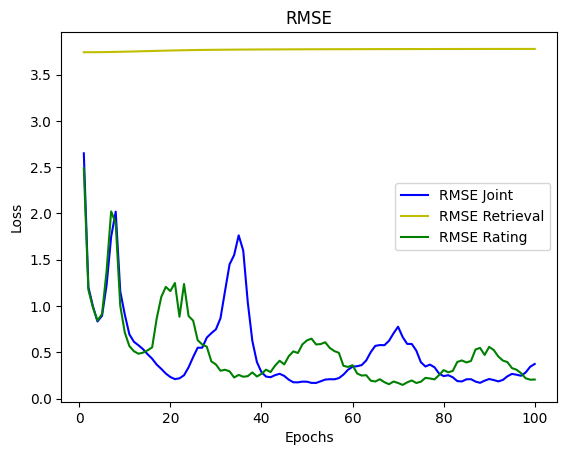

In [50]:
RMSE_joint = history_joint_model.history['root_mean_squared_error']
RMSE_retrieval = history_retrieval_model.history['root_mean_squared_error']
RMSE_rating = history_rating_model.history['root_mean_squared_error']

draw_plot('RMSE', RMSE_joint,RMSE_retrieval,RMSE_rating)

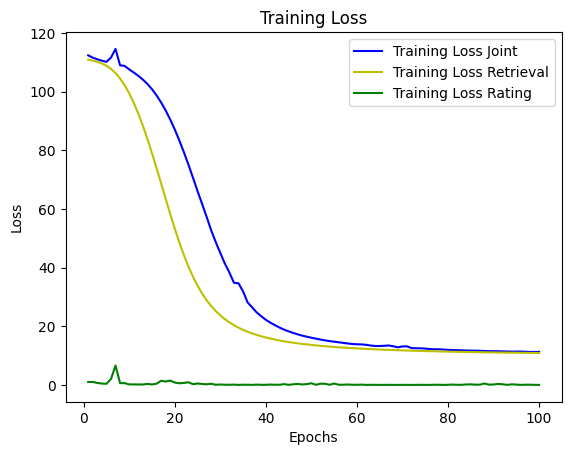

In [51]:
total_loss_values_joint = history_joint_model.history['total_loss']
total_loss_values_retrieval = history_retrieval_model.history['total_loss']
total_loss_values_rating = history_rating_model.history['total_loss']

draw_plot('Training Loss', total_loss_values_joint,total_loss_values_retrieval,total_loss_values_rating)

## Making predictions

In [52]:
trained_movie_embeddings, trained_user_embeddings, predicted_rating = model({
      "user_id": np.array(["3avc3TUJioP8XGD0bLK9xtV7uIG3"]),
      "book_isbn": np.array(["09781880685358"])
  })
print("Predicted rating:")
print(predicted_rating)

Predicted rating:
tf.Tensor([[3.6408298]], shape=(1, 1), dtype=float32)


In [53]:
user_id = ["3avc3TUJioP8XGD0bLK9xtV7uIG3"]
isbn_list = set(books_df["isbn"])
for isbn in isbn_list:
    trained_movie_embeddings, trained_user_embeddings, predicted_rating = model({
      "user_id": np.array(user_id),
      "book_isbn": np.array([isbn])
    })
    print(predicted_rating)

tf.Tensor([[2.9733136]], shape=(1, 1), dtype=float32)
tf.Tensor([[4.400697]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.86580765]], shape=(1, 1), dtype=float32)
tf.Tensor([[3.0317476]], shape=(1, 1), dtype=float32)
tf.Tensor([[2.8459737]], shape=(1, 1), dtype=float32)
tf.Tensor([[5.027744]], shape=(1, 1), dtype=float32)
tf.Tensor([[3.3185782]], shape=(1, 1), dtype=float32)
tf.Tensor([[3.3901904]], shape=(1, 1), dtype=float32)
tf.Tensor([[5.117861]], shape=(1, 1), dtype=float32)
tf.Tensor([[5.12155]], shape=(1, 1), dtype=float32)
tf.Tensor([[4.0401764]], shape=(1, 1), dtype=float32)
tf.Tensor([[3.3359234]], shape=(1, 1), dtype=float32)
tf.Tensor([[4.5108037]], shape=(1, 1), dtype=float32)
tf.Tensor([[3.411014]], shape=(1, 1), dtype=float32)
tf.Tensor([[4.207669]], shape=(1, 1), dtype=float32)
tf.Tensor([[3.185547]], shape=(1, 1), dtype=float32)
tf.Tensor([[4.5727973]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.88299626]], shape=(1, 1), dtype=float32)
tf.Tensor([[2.7922175]], shape=(1,

tf.Tensor([[2.838566]], shape=(1, 1), dtype=float32)
tf.Tensor([[3.7046201]], shape=(1, 1), dtype=float32)
tf.Tensor([[3.3135118]], shape=(1, 1), dtype=float32)
tf.Tensor([[3.5011365]], shape=(1, 1), dtype=float32)
tf.Tensor([[4.3098435]], shape=(1, 1), dtype=float32)
tf.Tensor([[3.4833481]], shape=(1, 1), dtype=float32)
tf.Tensor([[3.0726118]], shape=(1, 1), dtype=float32)
tf.Tensor([[1.5106357]], shape=(1, 1), dtype=float32)
tf.Tensor([[1.8610637]], shape=(1, 1), dtype=float32)
tf.Tensor([[4.305649]], shape=(1, 1), dtype=float32)
tf.Tensor([[5.6600122]], shape=(1, 1), dtype=float32)
tf.Tensor([[3.0703733]], shape=(1, 1), dtype=float32)
tf.Tensor([[4.064699]], shape=(1, 1), dtype=float32)
tf.Tensor([[6.6535993]], shape=(1, 1), dtype=float32)
tf.Tensor([[2.9935777]], shape=(1, 1), dtype=float32)
tf.Tensor([[1.7980903]], shape=(1, 1), dtype=float32)
tf.Tensor([[2.543382]], shape=(1, 1), dtype=float32)
tf.Tensor([[3.189584]], shape=(1, 1), dtype=float32)
tf.Tensor([[2.3157022]], shape=(1

tf.Tensor([[4.091602]], shape=(1, 1), dtype=float32)
tf.Tensor([[5.7990556]], shape=(1, 1), dtype=float32)
tf.Tensor([[3.6145077]], shape=(1, 1), dtype=float32)
tf.Tensor([[5.142461]], shape=(1, 1), dtype=float32)
tf.Tensor([[3.3304617]], shape=(1, 1), dtype=float32)
tf.Tensor([[3.5752106]], shape=(1, 1), dtype=float32)
tf.Tensor([[4.543802]], shape=(1, 1), dtype=float32)
tf.Tensor([[2.1185434]], shape=(1, 1), dtype=float32)
tf.Tensor([[3.5223377]], shape=(1, 1), dtype=float32)
tf.Tensor([[6.543635]], shape=(1, 1), dtype=float32)
tf.Tensor([[4.214686]], shape=(1, 1), dtype=float32)
tf.Tensor([[3.138461]], shape=(1, 1), dtype=float32)
tf.Tensor([[3.054106]], shape=(1, 1), dtype=float32)
tf.Tensor([[3.40166]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.8680565]], shape=(1, 1), dtype=float32)
tf.Tensor([[2.9204383]], shape=(1, 1), dtype=float32)
tf.Tensor([[3.730451]], shape=(1, 1), dtype=float32)
tf.Tensor([[3.1556847]], shape=(1, 1), dtype=float32)
tf.Tensor([[3.2143362]], shape=(1, 1),

tf.Tensor([[4.394893]], shape=(1, 1), dtype=float32)
tf.Tensor([[5.0819545]], shape=(1, 1), dtype=float32)
tf.Tensor([[2.5810847]], shape=(1, 1), dtype=float32)
tf.Tensor([[3.6200085]], shape=(1, 1), dtype=float32)
tf.Tensor([[5.161535]], shape=(1, 1), dtype=float32)
tf.Tensor([[3.888107]], shape=(1, 1), dtype=float32)
tf.Tensor([[3.8163493]], shape=(1, 1), dtype=float32)
tf.Tensor([[2.9608996]], shape=(1, 1), dtype=float32)
tf.Tensor([[4.0962405]], shape=(1, 1), dtype=float32)
tf.Tensor([[3.6636317]], shape=(1, 1), dtype=float32)
tf.Tensor([[3.2235434]], shape=(1, 1), dtype=float32)
tf.Tensor([[5.0978913]], shape=(1, 1), dtype=float32)
tf.Tensor([[4.445193]], shape=(1, 1), dtype=float32)
tf.Tensor([[3.1521037]], shape=(1, 1), dtype=float32)
tf.Tensor([[4.1868176]], shape=(1, 1), dtype=float32)
tf.Tensor([[2.7627957]], shape=(1, 1), dtype=float32)
tf.Tensor([[2.5325472]], shape=(1, 1), dtype=float32)
tf.Tensor([[5.4540944]], shape=(1, 1), dtype=float32)
tf.Tensor([[2.477497]], shape=(1

tf.Tensor([[3.0056334]], shape=(1, 1), dtype=float32)
tf.Tensor([[4.2613444]], shape=(1, 1), dtype=float32)
tf.Tensor([[3.1655242]], shape=(1, 1), dtype=float32)
tf.Tensor([[3.3416069]], shape=(1, 1), dtype=float32)
tf.Tensor([[2.6628647]], shape=(1, 1), dtype=float32)
tf.Tensor([[3.0332055]], shape=(1, 1), dtype=float32)
tf.Tensor([[3.0096817]], shape=(1, 1), dtype=float32)
tf.Tensor([[2.4031613]], shape=(1, 1), dtype=float32)
tf.Tensor([[2.8838313]], shape=(1, 1), dtype=float32)
tf.Tensor([[3.1691308]], shape=(1, 1), dtype=float32)
tf.Tensor([[2.2719195]], shape=(1, 1), dtype=float32)
tf.Tensor([[3.3194926]], shape=(1, 1), dtype=float32)
tf.Tensor([[5.4109855]], shape=(1, 1), dtype=float32)
tf.Tensor([[2.7062304]], shape=(1, 1), dtype=float32)
tf.Tensor([[3.2434537]], shape=(1, 1), dtype=float32)
tf.Tensor([[3.1830153]], shape=(1, 1), dtype=float32)
tf.Tensor([[4.3643517]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.6164787]], shape=(1, 1), dtype=float32)


### Save the model 

In [54]:
model.retrieval_task = tfrs.tasks.Retrieval()  # Removes the metrics.
model.compile()
model.save("multi_recc3")

INFO:tensorflow:Assets written to: multi_recc3\assets


INFO:tensorflow:Assets written to: multi_recc3\assets


In [55]:
# load model
model = tf.keras.models.load_model("multi_recc3")

In [56]:
# Convert the model
converter = tf.lite.TFLiteConverter.from_saved_model("multi_recc3") # path to the SavedModel directory
tflite_model = converter.convert()

# Save the model.
with open('model3.tflite', 'wb') as f:
    f.write(tflite_model)

### Tf Lite

In [57]:
interpreter = tf.lite.Interpreter(model_path="model3.tflite")
interpreter.allocate_tensors()

#Get input details
input_details = interpreter.get_input_details()
for input_tensor in input_details:
    print("Input name:", input_tensor["name"])
    print("Input shape:", input_tensor["shape"])
    print("Input data type:", input_tensor["dtype"])
    print()
#Get output details
output_details = interpreter.get_output_details()
for output_tensor in output_details:
    print("Output name:", output_tensor["name"])
    print("Output shape:", output_tensor["shape"])
    print("Output data type:", output_tensor["dtype"])
    print()

Input name: serving_default_args_0:0
Input shape: [1]
Input data type: <class 'numpy.bytes_'>

Input name: serving_default_args_0_1:0
Input shape: [1]
Input data type: <class 'numpy.bytes_'>

Output name: StatefulPartitionedCall_2:0
Output shape: []
Output data type: <class 'numpy.float32'>

Output name: StatefulPartitionedCall_2:2
Output shape: [1 1]
Output data type: <class 'numpy.float32'>

Output name: StatefulPartitionedCall_2:1
Output shape: []
Output data type: <class 'numpy.float32'>



In [58]:
# Prepare the input data
input_data_isbn = np.array([b'09780143036357'], dtype=np.bytes_)
input_data_user_id = np.array(['3avc3TUJioP8XGD0bLK9xtV7uIG3'], dtype=np.bytes_)

input_details = interpreter.get_input_details()
interpreter.set_tensor(input_details[0]['index'], input_data_isbn)
interpreter.set_tensor(input_details[1]['index'], input_data_user_id)

# Run the inference
interpreter.invoke()

# Retrieve the output results
output_details = interpreter.get_output_details()

output_data_prediction = interpreter.get_tensor(output_details[0]['index'])
output_data_probabilities = interpreter.get_tensor(output_details[1]['index'])
output_data_score = interpreter.get_tensor(output_details[2]['index'])

# Process the output
#prediction = output_data_prediction.squeeze()
probabilities = output_data_probabilities.squeeze()
#score = output_data_score.squeeze()

# Print the results
#print("Prediction:", prediction)
print("Probability:", probabilities)
#print("Score:", score)

Probability: 3.2864304


### Tensorflow recommenders 

#### Brute Force

In [59]:
# Create a model that takes in raw query features, and
index = tfrs.layers.factorized_top_k.BruteForce(model.user_model)
# recommends books out of the entire books dataset.
index.index_from_dataset(
  tf.data.Dataset.zip((books.batch(100), books.batch(100).map(model.book_model)))
)

# Get recommendations.
_, isbns = index(np.array(["Pgzb07La4DUNOhYPzYXHA7CdfNi1"]))
print(f"Recommendations for user: {isbns[0, :10]}")

Recommendations for user: [b'09780140286014' b'09780618257768' b'09781857024074' b'09780465014903'
 b'09781592289806' b'09780590428880' b'09781859843406' b'09780321209184'
 b'09780195117950' b'09780140448948']


#### Save the brute force model

In [60]:
index.save("brute_force_model3")

INFO:tensorflow:Assets written to: brute_force_model3\assets


INFO:tensorflow:Assets written to: brute_force_model3\assets


In [61]:
# test loading 
loaded = tf.saved_model.load("brute_force_model3")

# Pass a user id in, get top predicted movie titles back.
scores, isbns = loaded(["Pgzb07La4DUNOhYPzYXHA7CdfNi1"])

print(f"Recommendations: {isbns[0][:5]}")

Recommendations: [b'09780140286014' b'09780618257768' b'09781857024074' b'09780465014903'
 b'09781592289806']


#### TFLite for the model 

In [62]:
# Convert the model
converter = tf.lite.TFLiteConverter.from_saved_model("brute_force_model3") # path to the SavedModel directory
tflite_model = converter.convert()

# Save the model.
with open('brute_force_model3.tflite', 'wb') as f:
    f.write(tflite_model)

#### Tf lite testing 

In [63]:
interpreter = tf.lite.Interpreter(model_path="brute_force_model3.tflite")
interpreter.allocate_tensors()

#Get input details
input_details = interpreter.get_input_details()
for input_tensor in input_details:
    print("Input name:", input_tensor["name"])
    print("Input shape:", input_tensor["shape"])
    print("Input data type:", input_tensor["dtype"])
    print()
#Get output details
output_details = interpreter.get_output_details()
for output_tensor in output_details:
    print("Output name:", output_tensor["name"])
    print("Output shape:", output_tensor["shape"])
    print("Output data type:", output_tensor["dtype"])
    print()

Input name: serving_default_input_1:0
Input shape: [1]
Input data type: <class 'numpy.bytes_'>

Output name: StatefulPartitionedCall_1:0
Output shape: [ 1 10]
Output data type: <class 'numpy.float32'>

Output name: StatefulPartitionedCall_1:1
Output shape: [ 1 10]
Output data type: <class 'numpy.bytes_'>



In [66]:
# Prepare the input data
input_data = np.array(["zwVJUfdC0oa9hWWp9uK0hRTM71j1"], dtype=np.bytes_)

input_details = interpreter.get_input_details()
interpreter.set_tensor(input_details[0]['index'], input_data)

# Run the inference
interpreter.invoke()

# Retrieve the output results
output_details = interpreter.get_output_details()

output_data_prediction = interpreter.get_tensor(output_details[0]['index'])
output_data_classes = interpreter.get_tensor(output_details[1]['index'])

# Process the output
#prediction = output_data_prediction.squeeze()
classes = output_data_classes.squeeze().astype(str)

# Print the results
#print("Prediction:", prediction)
print("Classes:", classes)

Classes: ['09781880685358' '09780385493628' '09780006498865' '09780307345974'
 '09780812969702' '09780674023857' '09780679601128' '09781579905088'
 '09780375714627' '09780060577865']
